# Recipe Scraper Solution 
![allrecipes-logo](
https://upload.wikimedia.org/wikipedia/en/thumb/c/cd/AllRecipes-Logo.svg/220px-AllRecipes-Logo.svg.png)

**Problem Statement:** *Scrape at least 100 recipes from the web, provide their ingredient lists and clean the ingredient data for the further calculation.*


For this task, I decided to choose one of my favourite recipe websites, <a href="https://www.allrecipes.com">allrecipes.com</a>. As I love cooking Indian recipes, I've performed the task on them!

I have divided the solution into three parts according to the csv files required. Setup required to run this notebook, is added in the [Setting up the Notebook](#setup-information) section.

### Table of Contents
- [About the Website](#about)
- [Libraries Used](#library)
- [Setting up the Notebook](#setup-information)
    - [Importing Modules](#import-mod)
- [Part 1: Web Scraping](#web-scraping)
- [Part 2: Data Cleaning](#data-cleaning)
    - [Breaking down the Data Cleaning process](#breakdown-cleaning)
    - [Resolving edge cases](#edge)
- [Part 3: Data Analysis](#data-analysis)

## About the Website <a id='about'></a>
<a href="https://www.allrecipes.com">allrecipes.com</a> is a javascript based website and uses infinite scrolling meaning that new recipes are loaded when the user scrolls till the end of the current page.


## Libraries Used <a id='library'></a>
<ol>
<b><li> Selenium</li></b>
    - Selenium is one of the most powerful tools for controlling and automating major browsers like Chrome, Firefox. Since `allrecipes.com` requires that the user scroll to the bottom for more recipes to load, I will be using Selenium to automate this process.
 
 
<b><li> BeautifulSoup</li></b>
    - Since I won't require scraping large amounts of data or performing intense web crawls, I preferred using BeautifulSoup - a Python library designed to parse HTML.
    
    
<b><li> spaCy</li></b>
    - spaCy is a free open-source library for Natural Language Processing in Python. It offers linguistic features like Part of Speech tagging and has multiple models to do so (the lightest one being 13 MB with 97% accuracy)
    
    
<b><li> NLTK</li></b>
     - NLTK is one of the most popular suite of libraries for Natural Language Processing. I will be using its Lemmatizer for the data cleaning process.
</ol>


<a id='setup-information'></a>
## Setting up the Notebook

All the modules required for this notebook are added in the `requirements.txt` file. To download them, run the command below

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install -U selenium

### Importing Modules <a id='import-mod'></a>

In [ ]:
import nltk

nltk.download('wordnet')

In [25]:
import pandas as pd
import time
import spacy
import string
import re
from nltk.stem import WordNetLemmatizer
import requests
from bs4 import BeautifulSoup

In case of any error of module not being found, please run the following command - `!pip install <package-name>`

In [26]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys

Selenium set up also requires downloading a web driver specifc for your browser and version. 

Please check your chrome browser like this - 


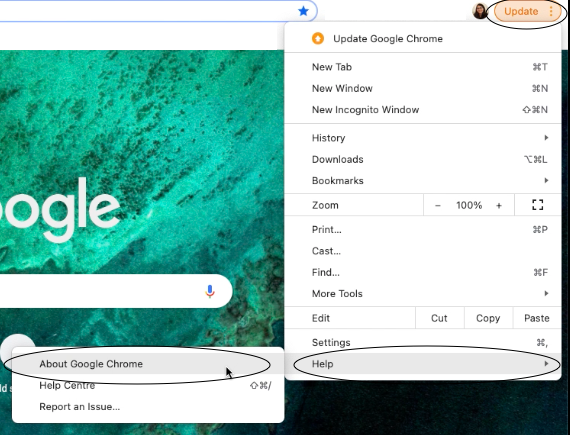

- If you are using Chrome version 92, please download <a href='https://chromedriver.storage.googleapis.com/index.html?path=92.0.4515.43/'>ChromeDriver 92.0.4515.43</a>
- If you are using Chrome version 91, please download  <a href='https://chromedriver.storage.googleapis.com/index.html?path=91.0.4472.101/'>ChromeDriver 91.0.4472.101</a>
- If you are using Chrome version 90, please download  <a href='https://chromedriver.storage.googleapis.com/index.html?path=90.0.4430.24/'>ChromeDriver 90.0.4430.24</a>
- If you are using Chrome version 89, please download  <a href='https://chromedriver.storage.googleapis.com/index.html?path=89.0.4389.23/'>ChromeDriver 89.0.4389.23</a>

In [27]:
#after unzipping, add the path to the chromedriver below 
#for example: '/usr/local/bin/chromedriver' (bin is the folder containing the executable file 'chromedriver')
CHROMEDRIVER_PATH = '/usr/local/bin'+ '/chromedriver' 

options = Options()
#preventing selenium from opening another 
options.headless = True

driver = webdriver.Chrome(CHROMEDRIVER_PATH, options=options)

## Part 1: Web Scraping <a id='web-scraping'></a>

I will be scraping the following <a href='https://www.allrecipes.com/search/results/?search=indian'>link</a> using Selenium.

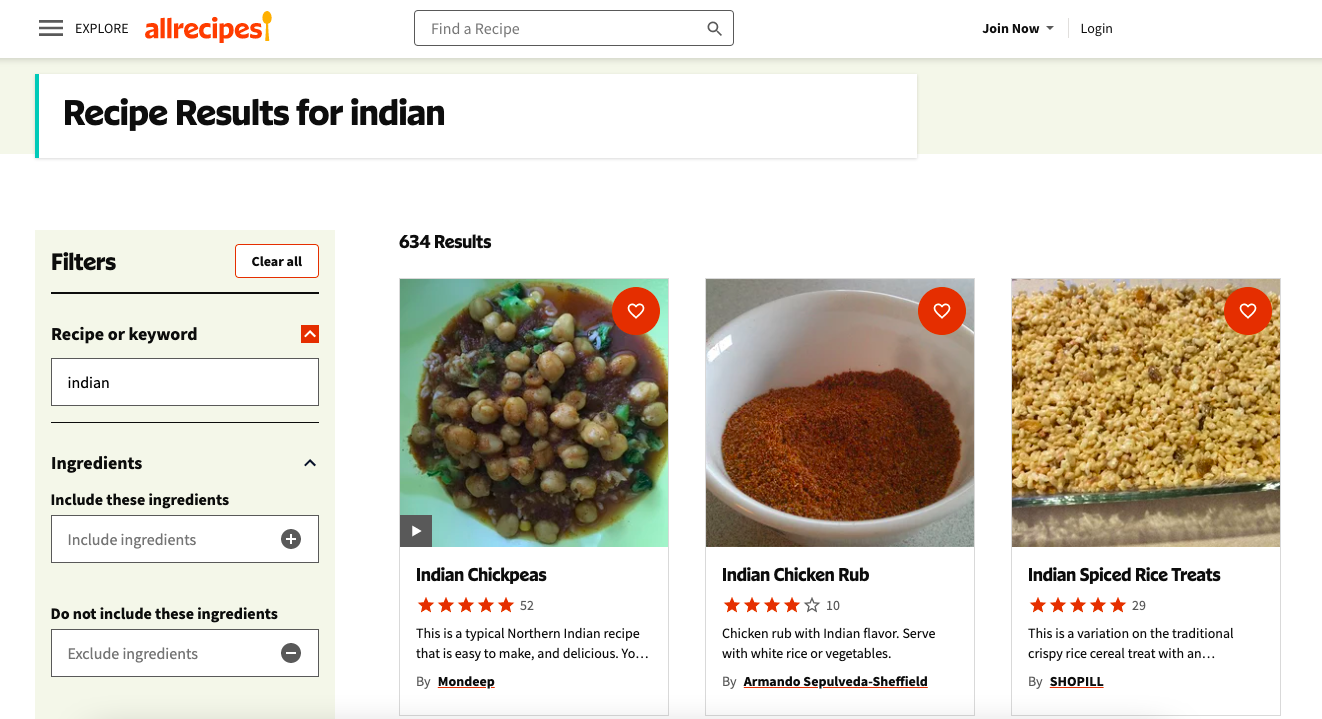

As stated before, to tackle the component of infinite scrolling on this page, I have automated the `PAGE DOWN` key till about a 100 recipes load. 

In [28]:
def collect_urls(URL):
    '''
        Scrolls to the bottom of the page till 100 recipes load. Collects the urls of all recipe cards present.
    '''
    #setting up the connection to the website
    driver.get(URL)
    #choosing an element that would be used to control the page
    element = driver.find_element_by_tag_name('body')

    #xpath to the recipe cards
    RECIPE_XPATH = '//div[@class="card__detailsContainer-left"]//a[@class="card__titleLink manual-link-behavior"]'

    #finding out the number of recipes that have been loaded initially
    num_div = len(driver.find_elements_by_xpath(RECIPE_XPATH))

    while(num_div <= 100):
        element.send_keys(Keys.PAGE_DOWN)

        #to ensure that the page loads properly and to accomodate for the internet speed
        time.sleep(3)

        recipe_cards = driver.find_elements_by_xpath(RECIPE_XPATH)

        #updating the number of recipes
        num_div=len(recipe_cards)
    
    return recipe_cards
    
def scrape_urls(recipe_cards):
    #creating an empty list to store the urls of the recipes on the page
    urls = []
    for card in recipe_cards:
        urls.append(card.get_attribute('href'))
    
    print(f'Scraped {len(set(urls))} urls successfully!')
    
    return urls

In [30]:
#this function will take a little time to run as it depends on the internet speed
recipe_cards = collect_urls("https://www.allrecipes.com/search/results/?search=indian")

urls = scrape_urls(recipe_cards)

#Now that the urls are scraped, we can close the browser
driver.close()

Scraped 119 urls successfully!


### Scraping the Ingredient List
Now that all the urls have been collected, I'm going to start scraping them for recipe names and ingredients

In [34]:
#creating an empty dataframe with the required columns
df=pd.DataFrame(columns=['url', 'name', 'ingredients'])

#parsing the html of every url that has been scraped
for url in urls:
    response = requests.get(url)
    #parsing the HTML using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')
    
    #getting the recipe name
    name = soup.find('h1', class_="headline heading-content")
    
    #getting the ingredient list
    ingredients = soup.find_all('span', class_="ingredients-item-name")
    
    #adding them to a new pandas series
    new = pd.DataFrame({
            'url': url,
            'name': name.get_text(),
            'ingredients': [ing.get_text().lower() for ing in ingredients]
        }, index=None)
    
    df = pd.concat([df, new])

In [37]:
#Checking the first 5 rows of the dataframe
df.head()

,url,name,ingredients
0,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,2 tablespoons vegetable oil
1,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,"4 cloves garlic, minced"
2,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,"½ cup onion, chopped"
3,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,1 tablespoon minced fresh ginger root
4,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,⅛ teaspoon garam masala


The dataframe is in the required formatting, so I'll save it as csv for future reference.

In [36]:
df.to_csv('rawData.csv', index=False, encoding='utf-8-sig')

## Part 2: Data Cleaning <a id='data-cleaning'></a>

In [38]:
#loading the scraped data
df_clean = pd.read_csv('rawData.csv')

In [39]:
#Snippet of the data to be cleaned
df_clean.head()

,url,name,ingredients
0,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,2 tablespoons vegetable oil
1,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,"4 cloves garlic, minced"
2,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,"½ cup onion, chopped"
3,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,1 tablespoon minced fresh ginger root
4,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,⅛ teaspoon garam masala


### Breaking down the data cleaning process <a id='breakdown-cleaning'></a>

After observing the data, it's clear that the `ingredients` column requires majority of the cleaning work.
<ol>
<li><b>Parts of Speech Tagging: </b> 
    
>This entails tagging every word contextually regarding its role in the sentence like verbs, nouns, adverbs, punctuation, etc. Ingredients will therefore get classified as <b>noun</b> during part of speech tagging. We can then filter out unnecessary words like minced, chopped, etc. 
    
To do so, I will be using `spaCy's` parts-of-speech tagging model `en_core_web_sm` which has an accuracy of 97%.</li>
<br>   
    
<li><b>Adding custom stop words: </b> 
    
>Stop words are generally the most common words that are used in a language like 'the', 'are', 'is', etc. Usually, we can use defined stop words in popular libraries like NLTK and filter them out. 
    
>However, currently I'm examining recipe data, where the 'common' words are a little different. Here, measures like 'teaspoons', 'tablespoons' along with non quantifible measures like 'bunch', 'pinch' are very common and used along with every ingredient entry.
    
To filter them out, I created a custom stop word list that includes quantifiable measures, non quantifiable measures, and other commonly used terms like 'can' from 'can of soup'.</li>
<br>

<li><b>Adding new words that aren't present in the spaCy model: </b> 
    
>To tackle with edge cases wherein that particular item isn't present in spaCy's model but is a popular ingredient in the recipes, I've created another list that would help retain them
</ol>


Further, all the data will be lemmatized using NLTK's lemmatizer to ensure that all inflected forms of words would be treated similarly.

In [40]:
#downloading the p-o-s model
!python -m spacy download en_core_web_sm

Traceback (most recent call last):
  File "/Users/shachi/opt/anaconda3/lib/python3.7/runpy.py", line 183, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/Users/shachi/opt/anaconda3/lib/python3.7/runpy.py", line 142, in _get_module_details
    return _get_module_details(pkg_main_name, error)
  File "/Users/shachi/opt/anaconda3/lib/python3.7/runpy.py", line 109, in _get_module_details
    __import__(pkg_name)
  File "/Users/shachi/text-mining-task/env/lib/python3.7/site-packages/spacy/__init__.py", line 14, in <module>
    from .cli.info import info  # noqa: F401
  File "/Users/shachi/text-mining-task/env/lib/python3.7/site-packages/spacy/cli/__init__.py", line 3, in <module>
    from ._util import app, setup_cli  # noqa: F401
  File "/Users/shachi/text-mining-task/env/lib/python3.7/site-packages/spacy/cli/_util.py", line 8, in <module>
    import typer
ModuleNotFoundError: No module named 'typer'


In [41]:
#loading the p-o-s model
nlp = spacy.load("en_core_web_sm")

#initiating the lemmatizer
wnl = WordNetLemmatizer()

#List of stop words
stop_words = set([
    #quantifiable measures 
    'cup', 'tsp','teaspoon',
    'inch', 'half',
    'tbsp','tablespoon', 'quart',
    #non quantifiable measures
    'piece','pinch', 'cube',
    'pound',  'ounce', 'cubed',
    'head', 'floret', 'bunch', 'dash', 'strip', 'chunk',
    #other commonly used terms
    'package', 'skinless', 'boneless', 'root', 'split',
    'stem', 'container', 'pod', 'cut', 'can'
])

#list of words not present in the p-o-s model
new_words = [
    'cashew', 'almond', 'half-and-half', 'cauliflower', 'potato',
    'margarine', 'radish', 'lettuce', 'amchoor', 'cardamom', 'couscous', 'turmeric'
]

In [42]:
def clean_ingredients(s):
    #removing all parenthesis, commas, and common phrases
    s = re.sub(r'\([^()]*\)|,|all-? ?purpose|self-? ?rising|bite-size?d?|stick', '', s)

    #splitting the sentence if there's 'and' or 'or' present to reduce it to a single ingredient
    s = re.split('\\b and\\b|\\bor\\b', s)[0]
    
    #keeping only alphabets, and removing any whitespaces 
    s= re.sub('[^A-Za-z\-]+', ' ', s).strip()
    
    #lemmatizing the words to reduce them to their root form
    lem = [wnl.lemmatize(word) for word in s.split()]
    
    #removing all the custom stop words 
    s = " ".join(word for word in lem if not word in stop_words).lower()
   
    #using part of speech tagging to only keep words that are NOUNS for eg. boiling water would return only water
    nouns = [token.text for token in nlp(s) if (token.pos_ == "NOUN" or token.text in new_words) ]
    
    return ' '.join(nouns)

In [43]:
df_clean['ingredients'] = df_clean['ingredients'].apply(clean_ingredients)

In [44]:
#after cleaning the data
df_clean.head(10)

,url,name,ingredients
0,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,oil
1,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,garlic
2,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,onion
3,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,ginger
4,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,garam masala
5,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,channa masala spice mix
6,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,tomato
7,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,water
8,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,garbanzo bean
9,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,salt


### Resolving edge cases <a id = 'edge'></a>
There are two edge cases that need to be corrected before the data can be declared as clean.

1. There's a discrepancy in the ingredients- **'clove',  'garlic',** and **'cloves of garlic'.** 
> Here, clove is used in context of two things - firstly as a spice and secondly as a segment of garlic. While 'clove' gets processed accurately, instances of 'cloves of garlic' get incorrectly filtered to 'clove garlic'.<br><br>
> I will be replacing all instances of 'clove garlic' to 'garlic' to fix this. 

2. The ingredient **'half-and-half'** gets processed to **'half'**. 
> I will be replacing all instances of 'half' with 'half-and-half'.

In [45]:
print("Context in which 'clove' appears: ")
display(df[df['ingredients'].str.contains('clove')].head(1))
display(df[df['ingredients'].str.contains('whole clove')].head(1))

#number of times 'garlic' occurs
print('Instances of "garlic":')
print(df_clean[df_clean['ingredients']=='garlic'].count())

#number of times 'clove garlic' occurs
print('\nInstances of "clove garlic":')
print(df_clean[df_clean['ingredients']=='clove garlic'].count())

Context in which 'clove' appears: 


,url,name,ingredients
1,https://www.allrecipes.com/recipe/46372/indian...,Indian Chickpeas,"4 cloves garlic, minced"


,url,name,ingredients
14,https://www.allrecipes.com/recipe/272441/chole...,Chole (Vegetarian Indian Chickpeas),"1 whole clove, or more to taste"


Instances of "garlic":
url            52
name           52
ingredients    52
dtype: int64

Instances of "clove garlic":
url            2
name           2
ingredients    2
dtype: int64


In [46]:
#instances of half-and-half in rawData.csv
print("Instances of 'half-and-half': ")
display(df[df['ingredients'].str.contains('half-and-half')])

#instances of half-and-half post processing
print("After post processing: ")
display(df_clean[df_clean['ingredients'].str.contains('half')])

Instances of 'half-and-half': 


,url,name,ingredients
14,https://www.allrecipes.com/recipe/106159/basic...,Basic Indian Curry with Paneer,whipping cream or half-and-half to taste
14,https://www.allrecipes.com/recipe/246717/india...,Indian Butter Chicken (Chicken Makhani),1 cup half-and-half
0,https://www.allrecipes.com/recipe/256598/shahi...,Shahi Tukray (Indian Bread Pudding),1 quart half-and-half
11,https://www.allrecipes.com/recipe/45957/chicke...,Chicken Makhani (Indian Butter Chicken),1 cup half-and-half


After post processing: 


,url,name,ingredients
79,https://www.allrecipes.com/recipe/246717/india...,Indian Butter Chicken (Chicken Makhani),half
309,https://www.allrecipes.com/recipe/256598/shahi...,Shahi Tukray (Indian Bread Pudding),half
852,https://www.allrecipes.com/recipe/45957/chicke...,Chicken Makhani (Indian Butter Chicken),half


In [47]:
#Fixing the edge cases
def correct_edge_cases():
    df_clean['ingredients'].replace({'clove garlic': 'garlic', 'half': 'half-and-half'}, inplace=True)
    
correct_edge_cases()

In [48]:
#saving part 2 of the solution
df_clean.to_csv('cleanData.csv', index = False)

## Part 3: Data Analysis <a id='data-analysis'></a>

In [49]:
#creating a new dataframe that includes the top 10 occuring ingredients 
top_ing = pd.DataFrame(df_clean['ingredients'].value_counts()[:10]).reset_index()
top_ing.columns = ['word', 'count']

### Visualizing the top 10 ingredients

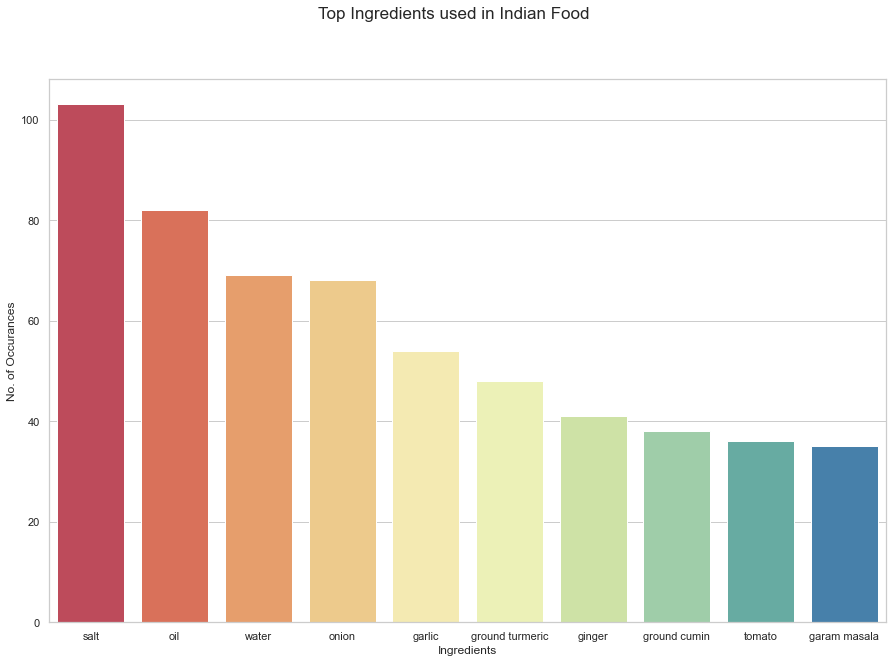

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

x = top_ing['word']
y = top_ing['count']

plt.figure(1, figsize=(15,10))

ax = sns.barplot(x=x,y=y,  palette='Spectral')
ax.set(xlabel='Ingredients', ylabel = 'No. of Occurances')

plt.suptitle('Top Ingredients used in Indian Food', fontsize=17);

In [51]:
def calculate_proportion():
    #create a new column in the dataframe
    top_ing['proportion'] = None
    
    #calculate the total number of unique recipes
    total = len(df_clean['name'].unique())
    
    #get the proportion of recipes that contain the ingredient
    top_ing['proportion'] = top_ing['word'].map(lambda x: df_clean[df_clean['ingredients'] == x].name.nunique()/total)

In [52]:
calculate_proportion()
display(top_ing)

,word,count,proportion
0,salt,103,0.798319
1,oil,82,0.630252
2,water,69,0.495798
3,onion,68,0.546218
4,garlic,54,0.436975
5,ground turmeric,48,0.394958
6,ginger,41,0.336134
7,ground cumin,38,0.310924
8,tomato,36,0.294118
9,garam masala,35,0.268908


In [53]:
#saving part 3 of the solution
top_ing.to_csv('results.csv', index=False, encoding='utf-8-sig')

## Conclusion


- Looking at the analysis, it's clear that apart from pantry staples like salt and oil, **onion** and **garlic** are the most used ingredients in the Indian Cuisine. 
- While it is known that spices are an integral part of indian food, it's interesting to get it verified by the data. **Ground turmeric**, **ginger**, **garam masala** and **ground cumin** are the front running ingredients.


## Future Work

- It would be interesting to analyze combinations of ingredients that occur together often.
- If enough data would be scraped, a recipe generator could be trained using neural networks!